In [1]:
from typing import Any, Generator, Tuple, Mapping, Sequence, Optional, Callable
from collections import namedtuple
import functools, inspect, time, random

import pandas as pd
import numpy as np
from absl import app
import haiku as hk
import jax
from jax.experimental import optix
from jax.tree_util import tree_multimap, tree_map, tree_reduce
import jax.numpy as jnp
from jax.lax import fori_loop
import tensorflow_datasets as tfds
import tensorflow_federated as tff
import tensorflow as tf

In [2]:
Batch = Mapping[str, jnp.ndarray]
LossFunction = Callable[[hk.Params, Batch], jnp.ndarray]
OptState = Any


# define hyperparameters format.
ServerHyperParams = namedtuple("ServerHyperParams", "num_epochs\
                                                     num_rounds\
                                                     seed")

# message to the client from server.
ClientMessage = namedtuple("ClientMessage", "params\
                                             opt_init_input")

# message to the server from client.
ServerMessage = namedtuple("ServerMessage", "aggregator_input\
                                             stateupdater_input")


# message to the server from client for book keeping.
DiagnosticsMessage = namedtuple("DiagnosticsMessage", "train_loss\
                                                       train_acc\
                                                       test_loss\
                                                       test_acc\
                                                       weight")
ClientOutput = Tuple[ServerMessage, DiagnosticsMessage]

# extracts messages from a list of client outputs.
@jax.partial(jax.jit, static_argnums=[1])  # fix extractor.
def extract_from_cout(
    couts: Sequence[ClientOutput],
    extractor: Callable[[ClientOutput], Any]
    ) -> Sequence[Any]:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  # TODO: use pytrees.transpose?
  # msgs = fori_loop(0, len(couts),
  #                    lambda i, msgs: msgs.append(extractor(couts[i])), [])
  msgs = [extractor(cout) for cout in couts]
  return msgs

def make_jax_batch(batch):
    jax_batch = {}
    for key in batch:
        jax_batch[key] = jnp.array(batch[key].numpy())
    return jax_batch

In [3]:
def load_2017annie_predict_EVD():
    X = np.loadtxt('../data/private/predict_EVD/X.csv', skiprows=1, delimiter=',')
    y = np.loadtxt('../data/private/predict_EVD/y.csv', skiprows=1, delimiter=',')
    assert (X.shape[0] == y.shape[0])
    return X,y

# This function is not stateless, due to the use of random.shuffle. It is used only once, before the training loop.
def split_by_age(X,y, batch_size, seed=0, requesting_client=0, test_ratio=0.5):
    ages = pd.read_csv('../data/private/0_raw_EbolaDatabase.csv')['age'].to_numpy()
    age_lims = [-1, 20, 40, 1e3]
    dss, ds_test = [], None
    
    for i, (lower, upper) in enumerate(zip(age_lims[:-1], age_lims[1:])):
        idx = np.asarray((lower < ages) & (ages <= upper)).nonzero()[0]
        random.shuffle(idx)
        if i == requesting_client:
            test_size = batch_size * (1 + int(len(idx) // batch_size * test_ratio))
            ds_test = tf.data.Dataset.from_tensor_slices(
                    {'features': X[idx[:test_size]], 'label':y[idx[:test_size]]}
                    ).batch(batch_size)
            idx = idx[test_size:]
#             test_batches = int(len(idx) // batch_size * test_ratio)+1
        dss.append( 
            tf.data.Dataset.from_tensor_slices({'features': X[idx], 'label':y[idx]})\
            .batch(batch_size)
        )
    
    if ds_test is None:
        raise ValueError("Unexpected 'requesting_client' argument: Expecting a non-negative int lower or equal to {}.".format(len(age_lims)-2))
    
    return dss, ds_test

In [4]:
# X, y = load_2017annie_predict_EVD()
# X_id = np.hstack((np.arange(X.shape[0]).reshape((X.shape[0], 1)), X))
# X_id

In [5]:
# dss, ds_test = split_by_age(X_id, y, 10)

In [6]:
# Neural network model.
def net_fn(batch: Batch) -> jnp.ndarray:
  """Logistic regression for 2-class classification."""
  x = batch["features"]
  logistic_reg = hk.Sequential([
      hk.Flatten(),
      hk.Linear(2), jax.nn.log_softmax
  ])
  return logistic_reg(x)
net: hk.Transformed = hk.transform(net_fn)

# Initialize neural network parameters 
def init(rng: jax.random.PRNGKey, batch: Batch) -> hk.Params:
  return net.init(rng, batch)

# get predictions from model.
def forward(params: hk.Params, batch: Batch):
  return jax.jit(net.apply)(params, batch)


# Training loss (cross-entropy).
@jax.jit
def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  preds = forward(params, batch)
  labels = hk.one_hot(batch["label"], 2)
  # TODO: Put weight decay into optimizer
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
  softmax_xent = -jnp.mean(labels * preds)
  return softmax_xent + 1e-4 * l2_loss

# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  preds = forward(params, batch)
  pred_class = jnp.argmax(preds, axis=-1)
  return jnp.mean(pred_class == batch["label"])

In [7]:
# one local update step.
@jax.partial(jax.jit, static_argnums=[2,4])  # fix loss function and optimizer.
def run_one_step(
    params: hk.Params,
    batch: Batch,
    client_opt: optix.InitUpdate,
    opt_state: OptState,
    loss: LossFunction
    ) -> Tuple[hk.Params, OptState]:
  """Learning rule (stochastic gradient descent)."""
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  grads = jax.grad(loss)(params, batch)
  updates, opt_state = client_opt.update(grads, opt_state)
  new_params = optix.apply_updates(params, updates)
  return new_params, opt_state  

# perform client updates.
def client_updater(
    msg: ClientMessage,
    ds: tf.data.Dataset,
    client_opt: optix.InitUpdate,
    loss: LossFunction
    ) -> ClientOutput:
  opt_state = client_opt.init(*msg.opt_init_input)
  # iterate through data making updates.
  new_params = msg.params
  for minibatch in ds:
    new_params, opt_state = run_one_step(new_params,
                                         make_jax_batch(minibatch),
                                         client_opt, 
                                         opt_state, 
                                         loss)
  # compute and return the change in parameters.
  params_update = tree_multimap(lambda x, y: x - y, new_params, msg.params)
  
  # TODO: replace with an function which constructs message  
  msg_to_server = ServerMessage(
      aggregator_input=params_update,
      stateupdater_input=None
  )

  diagnostic_msg = DiagnosticsMessage(
      train_loss=0,
      train_acc=1,
      test_loss=0,
      test_acc=1,
      weight=1
  )
  return msg_to_server, diagnostic_msg

In [8]:
# aggregate client updates.
# TODO: make the aggregator stateful.
@jax.jit
def average_params(params_list: Sequence[hk.Params]) -> hk.Params: 
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  num_params = len(params_list)
  params_sum = functools.reduce(
      lambda t1, t2: tree_multimap(sum, t1, t2), params_list)
  params_avg = tree_map(lambda x: x/num_params, params_sum)
  return params_avg

In [9]:
# aggregate diagnositcs.
@jax.jit
def agg_diagnostics(
    client_outputs: Sequence[ClientOutput]) -> DiagnosticsMessage:
  d_msgs = extract_from_cout(client_outputs, lambda cout: cout[1])
  # TODO: aggregate and report statistics
  return d_msgs[0]


# update server params.
@jax.partial(jax.jit, static_argnums=[2,4])  # fix optimizer and aggregator.
def server_updater(
    server_params: hk.Params,
    client_outputs: Sequence[ClientOutput],
    server_opt: optix.InitUpdate,
    opt_state: OptState,
    aggregator: Callable[[Sequence[Any]], hk.Params]
    ) -> Tuple[hk.Params, OptState]:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  agg_inputs = extract_from_cout(client_outputs,
                                 lambda cout: cout[0].aggregator_input)
  agg_update = aggregator(agg_inputs)
  eff_grads = tree_map(lambda x: -1.0*x, agg_update)  # effective gradient.
  updates, opt_state = server_opt.update(eff_grads, opt_state)
  # TODO: allow opt_state to also be explicitly updated by state_updater
  server_params = optix.apply_updates(server_params, updates)
  return server_params, opt_state

# one round of federated learning.
def run_one_round(
    server_params: hk.Params,
    hyperparams: ServerHyperParams,
    client_data: Sequence[tf.data.Dataset],
    client_opt: optix.InitUpdate,
    server_opt: optix.InitUpdate,
    opt_state: OptState,
    aggregator: Callable[[Sequence[Any]], hk.Params],
    loss: LossFunction,
    rng: jax.random.PRNGKey
) -> Tuple[hk.Params, OptState]:
  
  print("computing updates from active clients.")
  # TODO: replace with an function which constructs message
  msg_to_clients = ClientMessage(
      params=server_params, 
      opt_init_input=[server_params])
  
  client_outputs = list(map(lambda ds: client_updater(
                          msg_to_clients,
                          ds,
                          client_opt,
                          loss), dss))
  print("aggregating client updates.")
  server_params, opt_state = server_updater(
      server_params,
      client_outputs,      
      server_opt,      
      opt_state,      
      aggregator)
  
  # TODO: aggregate and incporate new diagnostics. needs state!
  diag_state = agg_diagnostics(client_outputs)
  
  return server_params, opt_state

In [10]:
# Testing one round of federated averaging.
batch_size=10
dss, ds_test = split_by_age(*load_2017annie_predict_EVD(), batch_size)

In [11]:
params = init(jax.random.PRNGKey(42), dss[0].as_numpy_iterator().next())

/home/grimberg/.local/share/virtualenvs/semester-project-privateML-TGzbS9iS/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/grimberg/.local/share/virtualenvs/semester-project-privateML-TGzbS9iS/lib/python3.7/site-packages/jax/lax/lax.py:4979: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [12]:
client_opt = optix.sgd(0.1)
server_opt = optix.sgd(1.0)
opt_state = server_opt.init(params)
rng = jax.random.PRNGKey(0)
hyperparams = ServerHyperParams(
    num_epochs = 5,
    num_rounds = 3,
    seed = 7
)

run_one_round(
    params,
    hyperparams,
    dss,
    client_opt,
    server_opt,
    opt_state,
    average_params,
    loss,
    rng
);

computing updates from active clients.
compiling: run_one_step
compiling: loss
compiling: run_one_step
compiling: loss
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout
compiling: average_params
compiling: extract_from_cout


In [11]:
def federated_learning(
    hyperparams: ServerHyperParams,
    client_data: Sequence[tf.data.Dataset],
    client_opt: optix.InitUpdate,
    server_opt: optix.InitUpdate,
    aggregator: Callable[[Sequence[hk.Params]], hk.Params],
    loss: LossFunction,
    init
    ) -> hk.Params:
  # initialize random generator, params, opt_state.
  rng = jax.random.PRNGKey(hyperparams.seed)
  # TODO: use synthethic data for init
  server_params = init(rng, client_data[0].as_numpy_iterator().next())
  opt_state = server_opt.init(server_params)
  rngs = jax.random.split(rng, hyperparams.num_rounds)
  for round_num, rng in enumerate(rngs):
    print("\nrunning round {}".format(round_num))
    server_params, opt_state = run_one_round(server_params, hyperparams, 
                                             client_data, client_opt, 
                                             server_opt, opt_state, 
                                             aggregator, loss, rng)
  return server_params

In [12]:
def eval_test_score(params: hk.Params, ds: tf.data.Dataset) -> jnp.ndarray:
    accs = []
    for batch in ds:
        accs.append(accuracy(params, make_jax_batch(batch)))
    return np.mean(accs)

In [32]:
# testing federated learning code.
bach_size = 10


hyperparams = ServerHyperParams(
    num_epochs = 100,
    num_rounds = 3,
    seed = 420
)

test_scores = {'global': [], 'local': []}# , 'similar': []}
for requesting_client in range(3):
    dss, ds_test = split_by_age(*load_2017annie_predict_EVD(), batch_size, requesting_client=requesting_client)

    opt_params_global = federated_learning(
        hyperparams,
        dss,
        optix.sgd(0.1),
        optix.sgd(1.0),
        average_params,
        loss,
        init
        );
    test_scores['global'].append( eval_test_score(opt_params_global, ds_test) )

    opt_params_local = federated_learning(
        hyperparams,
        dss[requesting_client:requesting_client+1],
        optix.sgd(0.1),
        optix.sgd(1.0),
        average_params,
        loss,
        init
        );
    test_scores['local'].append( eval_test_score(opt_params_local, ds_test) )


running round 0
computing updates from active clients.
compiling: run_one_step
compiling: run_one_step
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout

running round 1
computing updates from active clients.
aggregating client updates.

running round 2
computing updates from active clients.
aggregating client updates.

running round 0
computing updates from active clients.
compiling: run_one_step
compiling: run_one_step
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout

running round 1
computing updates from active clients.
aggregating client updates.

running round 2
computing updates from active clients.
aggregating client updates.

running round 0
computing updates from active clients.
compiling: run_one_step
compiling: run_one_step
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout

running round 1
computing updates from active clients.
aggregating client updates.

running round 2
co

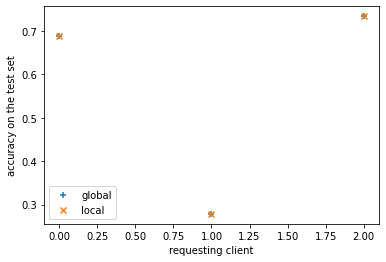

In [33]:
import matplotlib.pyplot as plt
markers = {'global': '+', 'local': 'x'}
for key, val in test_scores.items():
    x = np.arange(len(val))
    plt.scatter(x, val, label=key, marker=markers[key])
plt.legend()
plt.xlabel('requesting client')
plt.ylabel('accuracy on the test set')
plt.show()

In [21]:
test_scores

{'global': 0.34444445, 'local': 0.34444445}

# Questions

1. Does the net.init also initialize the output layer based on batch size?